<a href="https://colab.research.google.com/github/russellbreaux/K-Means-Clustering/blob/main/ARCVampire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict
import copy
import zipfile
import json
import os
import networkx as nx

In [ ]:
{
    "train": [
        {"input": [[1,0],[0,1]], "output": [[0,1],[1,0]]}
    ],
    "test": [
        {"input": [[0,1],[1,0]], "output": [[1,0],[0,1]]}
    ]
}

{'train': [{'input': [[1, 0], [0, 1]], 'output': [[0, 1], [1, 0]]}],
 'test': [{'input': [[0, 1], [1, 0]], 'output': [[1, 0], [0, 1]]}]}

In [ ]:
# Datasets
# Public training: 400 tasks
# Public evaluation: 400 tasks

from google.colab import drive
drive.mount('/content/drive')


train_data = []
eval_data = []

with zipfile.ZipFile('/content/drive/MyDrive/ARC_data.zip', 'r') as z:
    for file in z.namelist():
      if file.endswith('.json'):
        with z.open(file) as f:
          json_data = json.load(f)

          if file.startswith('training/'):
            train_data.append({
              'train': json_data.get('train', []),
              'test': json_data.get('test', []),
              'filename': file
            })
          elif file.startswith('evaluation/'):
            eval_data.append({
              'train': json_data.get('train', []),
              'test': json_data.get('test', []),
              'filename': file
            })
          else:
            raise ValueError("Oh dear.")

train = pd.DataFrame(train_data)
eval = pd.DataFrame(eval_data)
# Each df: two columns, train and test (plus filename)
# Each column: list of dicts with keys 'input' and 'output'
train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,train,test,filename
0,"[{'input': [[0, 7, 7], [7, 7, 7], [0, 7, 7]], ...","[{'input': [[7, 0, 7], [7, 0, 7], [7, 7, 0]], ...",training/007bbfb7.json
1,"[{'input': [[0, 0, 0, 0, 0, 0], [0, 0, 3, 0, 0...","[{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",training/00d62c1b.json
2,"[{'input': [[0, 1, 0], [1, 1, 0], [0, 1, 0], [...","[{'input': [[1, 1, 1], [0, 1, 0], [0, 1, 0], [...",training/017c7c7b.json
3,"[{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 6...","[{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0...",training/025d127b.json
4,"[{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",training/045e512c.json


<Axes: >

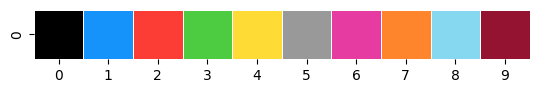

In [ ]:
color_dict = {
    0: "#000000",
    1: "#1593FB",
    2: "#FB3D36",
    3: "#4DCC42",
    4: "#FFDC35",
    5: "#999999",
    6: "#E63BA1",
    7: "#FF852D",
    8: "#86D8F0",
    9: "#931331"
    }

colormap = {
    0: "black",
    1: "blue",
    2: "red",
    3: "green",
    4: "yellow",
    5: "grey",
    6: "pink",
    7: "orange",
    8: "cyan",
    9: "maroon"
    }

colors = sns.color_palette(color_dict.values())
sns.heatmap(np.array([0,1,2,3,4,5,6,7,8,9]).reshape(1, 10), cmap=colors, annot=False, vmin=0, vmax=9, fmt="d", linewidths=.5, cbar=False, square=True)

In [ ]:
def display(skill):
  f, ax = plt.subplots(nrows=len(skill['train']), ncols=4, figsize=(8 + 1, 2*len(skill['train']) + 1))
  for i in range(len(skill['train'])):
    sns.heatmap(skill['train'][i]['input'], ax=ax[i,0], cmap=colors, annot=False, vmin=0, vmax=9, fmt="d", linewidths=.5, cbar=False, square=True)
    sns.heatmap(skill['train'][i]['output'], ax=ax[i,1], cmap=colors, annot=False, vmin=0, vmax=9, fmt="d", linewidths=.5, cbar=False, square=True)

    for j in range(4):
      ax[i,j].axes.xaxis.set_visible(False)
      ax[i,j].axes.yaxis.set_visible(False)


  sns.heatmap(skill['test'][0]['input'], ax=ax[0,2], cmap=colors, annot=False, vmin=0, vmax=9, fmt="d", linewidths=.5, cbar=False, square=True)
  sns.heatmap(skill['test'][0]['output'], ax=ax[0,3], cmap=colors, annot=False, vmin=0, vmax=9, fmt="d", linewidths=.5, cbar=False, square=True)

  ax[0,0].set_title('Input')
  ax[0,1].set_title('Output')
  ax[0,2].set_title('Test Input')
  ax[0,3].set_title('Test Output')

  plt.tight_layout()

  print("Train dimensions:")
  for i in skill['train']:
    print(f"({len(i['input'])}x{len(i['input'][0])})  ->  ({len(i['output'])}x{len(i['output'][0])})")

  print("Test dimensions:")
  print(f"({len(skill['test'][0]['input'])}x{len(skill['test'][0]['input'][0])})  ->  ({len(skill['test'][0]['output'])}x{len(skill['test'][0]['output'][0])})")


In [ ]:
s = "training/363442ee.json"
train.loc[train['filename'] == s]

,train,test,filename
74,"[{'input': [[4, 2, 2, 5, 0, 0, 0, 0, 0, 0, 0, ...","[{'input': [[3, 3, 9, 5, 0, 0, 0, 0, 0, 0, 0, ...",training/363442ee.json


Index: 1
Train dimensions:
(6x6)  ->  (6x6)
(10x10)  ->  (10x10)
(10x10)  ->  (10x10)
(10x10)  ->  (10x10)
(20x20)  ->  (20x20)
Test dimensions:
(20x20)  ->  (20x20)


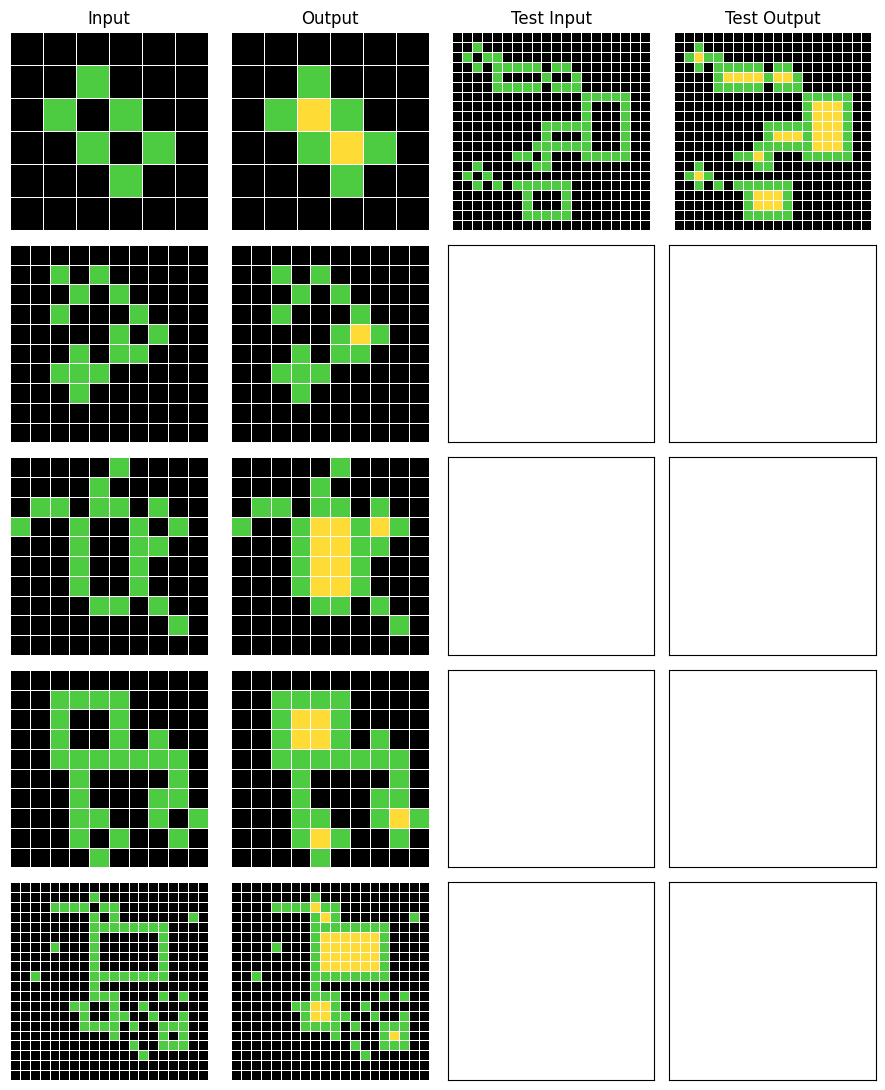

In [ ]:
idx = 1
print(f"Index: {idx}")
#print(train.iloc[idx])
display(train.iloc[idx])

In [ ]:
def plot_graph(skill):
  f, ax = plt.subplots(nrows=len(skill['train']), ncols=4, figsize=(8 + 1, 2*len(skill['train']) + 1))
  for i in range(len(skill['train'])):
    arr_input = np.array(skill['train'][i]['input'])
    arr_output = np.array(skill['train'][i]['output'])
    G_input = nx.grid_2d_graph(arr_input.shape[0], arr_input.shape[1])
    G_output = nx.grid_2d_graph(arr_output.shape[0], arr_output.shape[1])

    pos_input = {(j, k): (k, -j) for j, k in G_input.nodes()}
    nx.draw(G_input, pos_input, ax=ax[i,0], node_size=100, node_color=[color_dict[value] for value in arr_input.flatten()], with_labels=False)

    pos_output = {(j, k): (k, -j) for j, k in G_output.nodes()}
    nx.draw(G_output, pos_output, ax=ax[i,1], node_size=100, node_color=[color_dict[value] for value in arr_output.flatten()], with_labels=False)

  arr_test_input = np.array(skill['test'][0]['input'])
  arr_test_output = np.array(skill['test'][0]['output'])
  G_test_input = nx.grid_2d_graph(arr_test_input.shape[0], arr_test_input.shape[1])
  G_test_output = nx.grid_2d_graph(arr_test_output.shape[0], arr_test_output.shape[1])

  pos_test_input = {(j, k): (k, -j) for j, k in G_test_input.nodes()}
  nx.draw(G_test_input, pos_test_input, ax=ax[0,2], node_size=100, node_color=[color_dict[value] for value in arr_test_input.flatten()], with_labels=False)

  pos_test_output = {(j, k): (k, -j) for j, k in G_test_output.nodes()}
  nx.draw(G_test_output, pos_test_output, ax=ax[0,3], node_size=100, node_color=[color_dict[value] for value in arr_test_output.flatten()], with_labels=False)

  for j in range(1, ax.shape[0]):
    ax[j,2].axes.xaxis.set_visible(False)
    ax[j,2].axes.yaxis.set_visible(False)
    ax[j,3].axes.xaxis.set_visible(False)
    ax[j,3].axes.yaxis.set_visible(False)


  ax[0,0].set_title('Input')
  ax[0,1].set_title('Output')
  ax[0,2].set_title('Test Input')
  ax[0,3].set_title('Test Output')

  #plt.axis('equal')
  plt.tight_layout()

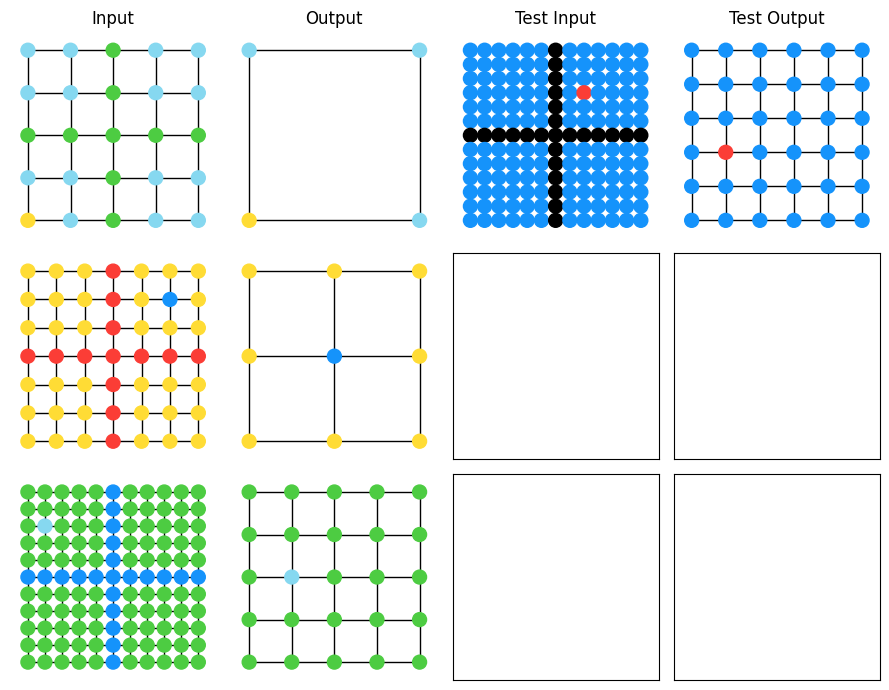

In [ ]:
idx = 64
#print(train.iloc[idx])
plot_graph(train.iloc[idx])

In [ ]:
# Transformation helper functions

def compress(grid: list): # https://www.kaggle.com/code/michaelhodel/program-synthesis-starter-notebook
    # Requires list of lists, will remove all rows and cols of same color
    ri = [i for i, r in enumerate(grid) if len(set(r)) == 1]
    ci = [j for j, c in enumerate(zip(*grid)) if len(set(c)) == 1]
    return np.array([[v for j, v in enumerate(r) if j not in ci] for i, r in enumerate(grid) if i not in ri])

def compress(grid: np.ndarray):
  # For numpy arrays; removes only rows and cols of all zeros
  arr = np.delete(grid, np.where(~np.any(grid, axis=1)), axis=0)
  arr = np.delete(arr, np.where(~np.any(arr, axis=0)), axis=1)
  return arr


def fill(arr, y, x, color, idx, diag=False):
  if y not in range(arr.shape[0]) or x not in range(arr.shape[1]):
    return
  if arr[y, x] != color:
    return
  else:
    arr[y,x] = idx
    fill(arr, y-1, x, color, idx, diag)
    fill(arr, y+1, x, color, idx, diag)
    fill(arr, y, x-1, color, idx, diag)
    fill(arr, y, x+1, color, idx, diag)
    if diag:
      fill(arr, y-1, x-1, color, idx, diag)
      fill(arr, y-1, x+1, color, idx, diag)
      fill(arr, y+1, x-1, color, idx, diag)
      fill(arr, y+1, x+1, color, idx, diag)
    return

def flood(arr, y, x, idx, diag=False):
  y = y
  x = x
  c = arr[y, x]
  arr[y, x] = idx
  fill(arr, y-1, x, c, idx, diag)
  fill(arr, y+1, x, c, idx, diag)
  fill(arr, y, x-1, c, idx, diag)
  fill(arr, y, x+1, c, idx, diag)
  if diag:
    fill(arr, y-1, x-1, c, idx, diag)
    fill(arr, y-1, x+1, c, idx, diag)
    fill(arr, y+1, x-1, c, idx, diag)
    fill(arr, y+1, x+1, c, idx, diag)
  return

def find_groups(lol, diag=False):  # Detect objects
  arr_init = np.array(lol)
  arr = np.array(lol)
  index = -1
  for y in range(arr.shape[0]):
    for x in range(arr.shape[1]):
      if arr[y, x] > 0:
        flood(arr, y, x, index, diag)
        index -=1
  #return arr
  objects = []
  for i in range(-1, arr.min() - 1, -1):
    obj = np.zeros_like(arr)
    obj[arr == i] = arr_init[arr == i]
    objects.append(compress(obj))
  return objects

def array_pull(arr):
  zeros_left = np.zeros(arr.shape[0], dtype=int)
  for i in range(arr.shape[0]):
    if arr[i] == 0:
      zeros_left[i:] += 1
    else:
      idx = int(i - zeros_left[i])
      hold = arr[i]
      arr[i] = 0
      arr[idx] = hold
  return arr

def flatten(xss):
    return [x for xs in xss for x in xs]

def flatten_all(row):
  l = []
  for i in row:
    l.append({'input': flatten(i['input']), 'output': flatten(i['output'])})
  return l

def match_groups(lol1, lol2):
  arr1 = np.array(lol1)
  arr2 = np.array(lol2)
  groups1 = find_groups(arr1)
  groups2 = find_groups(arr2)
  matches = []
  for i in groups1:
    for j in groups2:
      if np.array_equal(i, j):
        matches.append(i)
        break
  return matches

def floodfill(arr, y, x, wall_color, fill_color):
  if y not in range(arr.shape[0]) or x not in range(arr.shape[1]):
    return False
  if arr[y,x] == wall_color or arr[y,x] == fill_color:
    return True
  if (floodfill(arr, y, x-1, wall_color, fill_color) and
          floodfill(arr, y, x+1, wall_color, fill_color) and
          floodfill(arr, y-1, x, wall_color, fill_color) and
          floodfill(arr, y+1, x, wall_color, fill_color)
  ):
    arr[y,x] = fill_color
    return True
  return False


In [ ]:
idx = 1
g = copy.deepcopy(train['train'][idx][0]['input'])
g = np.array(g)
print(g)
floodfill(g,3,3,3,4)
print(g)

[[0 0 0 0 0 0]
 [0 0 3 0 0 0]
 [0 3 0 3 0 0]
 [0 0 3 0 3 0]
 [0 0 0 3 0 0]
 [0 0 0 0 0 0]]
[[0 0 0 0 0 0]
 [0 0 3 0 0 0]
 [0 3 0 3 0 0]
 [0 0 3 4 3 0]
 [0 0 0 3 0 0]
 [0 0 0 0 0 0]]


In [ ]:
# Transformation functions

def pull(lol, dir):    # up 0, down 1, left 2, right 3
  arr = np.array(lol)
  match(dir):
    case 0:
      for i in range(arr.shape[1]):
        arr[:,i] = array_pull(arr[:,i])
    case 1:
      for i in range(arr.shape[1]):
        arr[:,i] = array_pull(arr[:,i][::-1])[::-1]
    case 2:
      for i in range(arr.shape[0]):
        arr[i] = array_pull(arr[i])
    case 3:
      for i in range(arr.shape[0]):
        arr[i] = array_pull(arr[i][::-1])[::-1]
  return arr

def scale(group: np.ndarray, factor: int):
  if factor > 0:
    scaled = np.zeros((group.shape[0]*factor, group.shape[1]*factor), dtype=int)
    for i in range(group.shape[0]):
      for j in range(group.shape[1]):
        scaled[i*factor:i*factor+factor,j*factor:j*factor+factor] = group[i,j]
  return scaled

def tesselate(grid: np.ndarray):
  h, w = grid.shape
  result = np.zeros((h**2, w**2), dtype=int)
  for i in range(h):
    for j in range(w):
      result[i*h:i*h+h, j*w:j*w+w] = grid
  return result

def paint_fill(grid, group:np.ndarray, color: int):  # 4-way
  filled_grid = np.array(grid)
  filled_group = np.array(group)
  h, w = grid.shape
  g_h, g_w = group.shape
  group_color = filled_group[filled_group != 0][0]
  for i in range(g_h):
    for j in range(g_w):
      floodfill(filled_group,i,j,group_color, color)
  for i in range(h - g_h):
    for j in range(w - g_w):
      if np.array_equal(grid[i:i+g_h, j:j+g_w], group):
        filled_grid[i:i+g_h, j:j+g_w] = filled_group
  return filled_grid



In [ ]:
a = train['train'][1][0]['input']
arr = np.array(a)
groups = find_groups(arr, diag=True)
print(groups[0])
print(arr)
arr2 = paint_fill(arr, groups[0], 4)
print(arr2)

[[0 3 0 0]
 [3 0 3 0]
 [0 3 0 3]
 [0 0 3 0]]
[[0 0 0 0 0 0]
 [0 0 3 0 0 0]
 [0 3 0 3 0 0]
 [0 0 3 0 3 0]
 [0 0 0 3 0 0]
 [0 0 0 0 0 0]]


RecursionError: maximum recursion depth exceeded in comparison

In [ ]:
! pip install torch_geometric

In [ ]:
! pip install arcle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.6/577.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 42.5 MB/s eta 0:00:00


In [ ]:
import torch
#import torch_geometric
import arcle
import gymnasium as gym
import time

In [ ]:
env = gym.make('ARCLE/O2ARCEnv-v2', render_mode='ansi')
obs, info = env.reset()

for _ in range(10):
    action = env.action_space.sample()
    obs, reward, term, trunc, info = env.step(action)
    if term or trunc:
        obs, info = env.reset()

env.close()

Problem Description:
{'id': '363442ee'} 
                                                                                                                          
                                                                                                                          
                                                                                                                          
                                                                                                                          
                                                                                                                          
                                                                                                                          
                                                                                                                          
                                                                                                  